In [1]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# A5サイズ(300dpi)
IMAGE_HEIGHT = 2480
IMAGE_WIDTH = 1748

In [6]:
def conv2d(x, W, stride=1, relu=True):
    net = tf.nn.conv2d(x,
                       filter=W,
                       strides=[1, stride, stride, 1],
                       padding='SAME')
    if relu:
        return tf.nn.relu(net)
    return net

In [7]:
def avg_pool(x, ksize=2, stride=2):
    net = tf.nn.avg_pool(x,
                         ksize=[1, ksize, ksize, 1],
                         strides=[1, stride, stride, 1],
                         padding='SAME')
    return net

In [ ]:
def model:
    net = {}
    net['input'] = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3).astype('float32')))
    net['conv1_1'] = conv2d(net['input'], W)
    net['conv1_2'] = conv2d(net['conv1_1'], W)
    net['pool1'] = avg_pool(net['conv1_2'])
    net['conv2_1'] = conv2d(net['pool1'], W)
    net['conv2_2'] = conv2d(net['conv2_1'], W)
    net['pool2'] = avg_pool(net['conv2_2'])
    net['conv3_1'] = conv2d(net['pool2'], W)
    net['conv3_2'] = conv2d(net['conv3_1'], W)
    net['conv3_3'] = conv2d(net['conv3_2'], W)
    net['conv3_4'] = conv2d(net['conv3_3'], W)
    net['pool3'] = avg_pool(net['conv3_4'], W)
    net['conv4_1'] = conv2d(net['pool3'], W)
    net['conv4_2'] = conv2d(net['conv4_1'], W)
    net['conv4_3'] = conv2d(net['conv4_2'], W)
    net['conv4_4'] = conv2d(net['conv4_3'], W)
    net['pool4'] = avg_pool(net['conv4_4'])
    net['conv5_1'] = conv2d(net['pool4'])
    net['conv5_2'] = conv2d(net['conv5_1'], W)
    net['conv5_3'] = conv2d(net['conv5_2'], W)
    net['conv5_4'] = conv2d(net['conv5_3'], W)
    net['pool5'] = avg_pool(net['conv5_4'])
    return net

コンテンツ画像のコスト関数
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

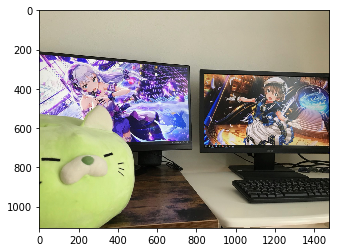

In [3]:
content_image = Image.open("../images/zunda.JPG")
plt.imshow(content_image)
plt.show()